In [58]:
import numpy as np
import matplotlib.pyplot as plt

# Sudoku Solver using Annealing

Napisz program poszukujący rozwiązania łamigłówki Sudoku za pomocą symulowanego
wyżarzania. 

- Plansza 9 ×9 ma zostać wczytana z pliku tekstowego, w którym pola puste
zaznaczone są znakiem x. 
- Jako funkcję kosztu przyjmij sumę powtórzeń cyfr występu-
jących w wierszach bloku 9 ×9, kolumnach bloku 9 ×9 oraz blokach 3 ×3. 
- Zaproponuj metodę generacji stanu sąsiedniego. 
- Przedstaw zależność liczby iteracji algorytmu od liczby pustych miejsc na planszy. 
- Czy Twój program jest w stanie znaleźć poprawne rozwiązanie dla każdej z testowanych konfiguracji wejściowych?

## Table of Contents

1. [Read Sudokus](#1-read-sudokus)
2. [Fill Sudoku](#2-fill-sudoku)  
    2.1 [Fill Sudoku](#21-fill-sudoku)  
    2.2 [Create sudoku](#22-create-sudoku)
3. [Annealing](#3-annealing)  
    3.1 [Cost Function](#31-cost-function)  
    3.2 [Annealing Algorithm](#32-annealing-algorithm)
4. [Vizualization](#4-vizualization)
5. [Results](#5-results)  
   5.1 [Test of hard sudokus](#51-test-of-hard-sudokus)  
   5.2 [Dependence of number of iterations on number of empty cells](#52-dependence-of-number-of-iterations-on-number-of-empty-cells)

## 1. Read Sudokus

sudokus were taken from [http://magictour.free.fr/top1465](http://magictour.free.fr/top1465)

In [59]:
def read_sudokus(filename="sudoku.txt"):
    with open(filename, "r") as f:
        sudokus = f.readlines()
    sudokus = [list(sudoku.strip()) for sudoku in sudokus]
    return np.array([np.reshape(row, (9, 9)) for row in sudokus])

## 2. Fill Sudoku

### 2.1 Fill Sudoku

Fill sudoku with all possible values randomly in each row.

In [60]:
def fill_sudoku(sudoku):
    positions = np.argwhere(sudoku == "x")
    positionssorted = dict(enumerate([[p for p in positions if p[0] == i] for i in range(9)]))
    for row in range(9):
        if len(positionssorted[row]) < 2:
            positionssorted.pop(row)
        nums = set([str(i) for i in range(1, 10)])
        for col in range(9):
            if sudoku[row, col] != "x":
                nums.remove(sudoku[row, col])
        for col in range(9):
            if sudoku[row, col] == "x":
                sudoku[row, col] = nums.pop()       
        
    return sudoku, positionssorted

### 2.2 Create sudoku

Create sudoku with `remove_nums` removed cells, requires sudoku in `filename` to be filled.

In [61]:
def create_sudoku(remove_nums, filename="solved.txt"):
    sudoku = read_sudokus(filename)[0]
    positions = [(i, j) for i in range(9) for j in range(9)]
    for _ in range(remove_nums):
        idx = np.random.choice(len(positions))
        pos = positions.pop(idx)
        sudoku[pos[0], pos[1]] = "x"
        
    return sudoku

## 3. Annealing

### 3.1 Cost Function

Checks how many times each number is repeated in columns and 3x3 blocks.

In [62]:
def count_inital_energy(sudoku):
    energy = 0
    for i in range(9):
        _, cnt = np.unique(sudoku[i], return_counts=True)
        energy += np.sum(cnt-1)
        _, cnt = np.unique(sudoku[:, i], return_counts=True)
        energy += np.sum(cnt-1)
        _, cnt = np.unique(sudoku[i//3*3:i//3*3+3, i%3*3:i%3*3+3], return_counts=True)
        energy += np.sum(cnt-1)
    return energy

In [63]:
def count_swap_energy(sudoku, x1, y1, x2, y2):
    current = 0
    _, cnt = np.unique(sudoku[:, y1], return_counts=True)
    current += np.sum(cnt-1)
    _, cnt = np.unique(sudoku[:, y2], return_counts=True)
    current += np.sum(cnt-1)
    _, cnt = np.unique(sudoku[x1//3*3:x1//3*3+3, y1//3*3:y1//3*3+3], return_counts=True)
    current += np.sum(cnt-1)
    _, cnt = np.unique(sudoku[x2//3*3:x2//3*3+3, y2//3*3:y2//3*3+3], return_counts=True)
    current += np.sum(cnt-1)
    return current

### 3.2 Annealing Algorithm

In [64]:
def annealing(sudoku, temp=1, step=0.999, max_iter=5000000):
    sudoku, positions = fill_sudoku(sudoku)
    energy = count_inital_energy(sudoku)
    data = {'iter': [], 'temp':[], 'energy': []}

    for i in range(max_iter):
        if energy == 0:   
            return sudoku, data, True
        if temp < 0.01:
            temp = min(1, temp+0.5)
    
        row = np.random.choice(list(positions.keys()))       
        c1, c2 = np.random.choice(len(positions[row]), 2, replace=False)
        x1, y1 = positions[row][c1][0], positions[row][c1][1]
        x2, y2 = positions[row][c2][0], positions[row][c2][1]
        prev = count_swap_energy(sudoku, x1, y1, x2, y2)
        sudoku[x1, y1], sudoku[x2, y2] = sudoku[x2, y2], sudoku[x1, y1]
        current = count_swap_energy(sudoku, x1, y1, x2, y2)
        try:
            acceptance = np.exp((prev - current) / temp)
        except:
            acceptance = 0
        if current < prev or (current - prev) * np.random.rand() < acceptance:
            energy += current - prev
        else:
            sudoku[x1, y1], sudoku[x2, y2] = sudoku[x2, y2], sudoku[x1, y1]
        temp *= step

        data['iter'].append(i)
        data['temp'].append(temp)
        data['energy'].append(energy)

    return sudoku, data, False

## 4. Vizualization

In [65]:
def plot(data):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].plot(data['iter'], data['temp'])
    ax[0].set_title('Temperature')
    ax[1].plot(data['iter'], data['energy'])
    ax[1].set_title('Energy')
    plt.show()

## 5. Results

### 5.1 Test of hard sudokus

In [68]:
def test_hard():
    sudoku = read_sudokus()
    for i in range(10):
        _, _, success = annealing(sudoku[i])
        print(f"Test {i+1}: {success}")

test_hard()


Test 1: True
Test 2: True
Test 3: True
Test 4: True
Test 5: True
Test 6: True
Test 7: False
Test 8: True
Test 9: True
Test 10: True


### 5.2 Dependence of number of iterations on number of empty cells

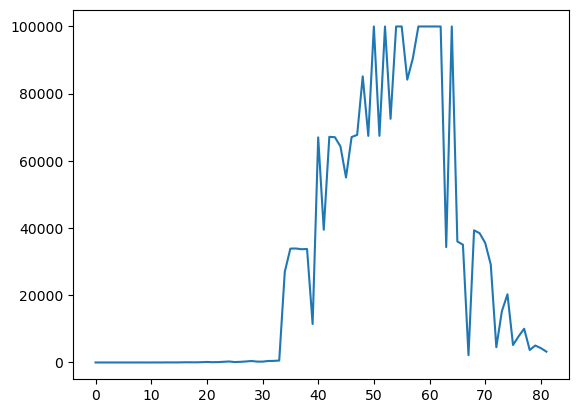

In [70]:
def depenence():
    data = np.zeros(82)
    for i in range(82):
        sum = 0
        for _ in range(3):
            sudoku = create_sudoku(i)
            _, res, _ = annealing(sudoku)
            if len(res['iter']) != 0:
                sum += res['iter'][-1]
        data[i] = sum / 3
    plt.plot(data)

depenence()

The most iterations are needed for sudokus between 50-60 empty cells. Those sudokus are the hardest to solve, due to the fact that there are many possible solutions, and the algorithm has to find the correct one.

---